In [1]:
import pandas as pd
import nannyml as nml
from IPython.display import display
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

reference_df, analysis_df, analysis_target_df = nml.load_synthetic_car_loan_dataset()

analysis_full_df = analysis_df.merge(analysis_target_df, left_index=True, right_index=True)

df_all = pd.concat([reference_df, analysis_full_df]).reset_index(drop=True)

display(df_all.head(3))


,car_value,salary_range,debt_to_income_ratio,loan_length,repaid_loan_on_prev_car,size_of_downpayment,driver_tenure,repaid,timestamp,y_pred_proba,period,y_pred
0,39811.0,40K - 60K €,0.632950,19.0,False,40%,0.212653,1.0,2018-01-01 00:00:00.000,0.99,reference,1
1,12679.0,40K - 60K €,0.718627,7.0,True,10%,4.927549,0.0,2018-01-01 00:08:43.152,0.07,reference,0
2,19847.0,40K - 60K €,0.721724,17.0,False,0%,0.520817,1.0,2018-01-01 00:17:26.304,1.00,reference,1


In [2]:
print(df_all.head(3).to_markdown(tablefmt="grid"))

+----+-------------+----------------+------------------------+---------------+---------------------------+-----------------------+-----------------+----------+-------------------------+----------------+-----------+----------+
|    |   car_value | salary_range   |   debt_to_income_ratio |   loan_length | repaid_loan_on_prev_car   | size_of_downpayment   |   driver_tenure |   repaid | timestamp               |   y_pred_proba | period    |   y_pred |
+====+=============+================+========================+===============+===========================+=======================+=================+==========+=========================+================+===========+==========+
|  0 |       39811 | 40K - 60K €    |               0.63295  |            19 | False                     | 40%                   |        0.212653 |        1 | 2018-01-01 00:00:00.000 |           0.99 | reference |        1 |
+----+-------------+----------------+------------------------+---------------+------------------

In [3]:
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='repaid',
    timestamp_column_name='timestamp',
    metrics=['roc_auc'],
    chunk_size=5000,
    problem_type='classification_binary',
)


In [4]:
estimator.fit(reference_df)

results = estimator.estimate(pd.concat([reference_df, analysis_df], ignore_index=True))

results_df = results.filter(period='analysis').to_df()

In [5]:
print(results_df.head(3).to_markdown(tablefmt="grid"))

+----+--------------------+----------------------------+----------------------------+--------------------------+---------------------------+----------------------------+-----------------------+---------------------------------+---------------------------+------------------------+--------------------------------------------+--------------------------------------------+----------------------------------+----------------------------------+------------------------+
|    | ('chunk', 'key')   |   ('chunk', 'chunk_index') |   ('chunk', 'start_index') |   ('chunk', 'end_index') | ('chunk', 'start_date')   | ('chunk', 'end_date')      | ('chunk', 'period')   |   ('roc_auc', 'sampling_error') |   ('roc_auc', 'realized') |   ('roc_auc', 'value') |   ('roc_auc', 'upper_confidence_boundary') |   ('roc_auc', 'lower_confidence_boundary') |   ('roc_auc', 'upper_threshold') |   ('roc_auc', 'lower_threshold') | ('roc_auc', 'alert')   |
+====+====================+============================+============

In [6]:
target_col = 'repaid'
pred_score_col = 'y_pred_proba'
actual_performance = []

for idx in results_df.index:
    chunk = results_df.loc[idx, 'chunk']
    start_index, end_index = chunk.loc['start_index'], chunk.loc['end_index']
    sub = df_all.loc[start_index:end_index]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    results_df.loc[idx, ('roc_auc', 'actual')] = actual_perf

In [7]:
print(results_df.head(3).to_markdown(tablefmt="grid"))

+----+--------------------+----------------------------+----------------------------+--------------------------+---------------------------+----------------------------+-----------------------+---------------------------------+---------------------------+------------------------+--------------------------------------------+--------------------------------------------+----------------------------------+----------------------------------+------------------------+-------------------------+
|    | ('chunk', 'key')   |   ('chunk', 'chunk_index') |   ('chunk', 'start_index') |   ('chunk', 'end_index') | ('chunk', 'start_date')   | ('chunk', 'end_date')      | ('chunk', 'period')   |   ('roc_auc', 'sampling_error') |   ('roc_auc', 'realized') |   ('roc_auc', 'value') |   ('roc_auc', 'upper_confidence_boundary') |   ('roc_auc', 'lower_confidence_boundary') |   ('roc_auc', 'upper_threshold') |   ('roc_auc', 'lower_threshold') | ('roc_auc', 'alert')   |   ('roc_auc', 'actual') |
+====+==========

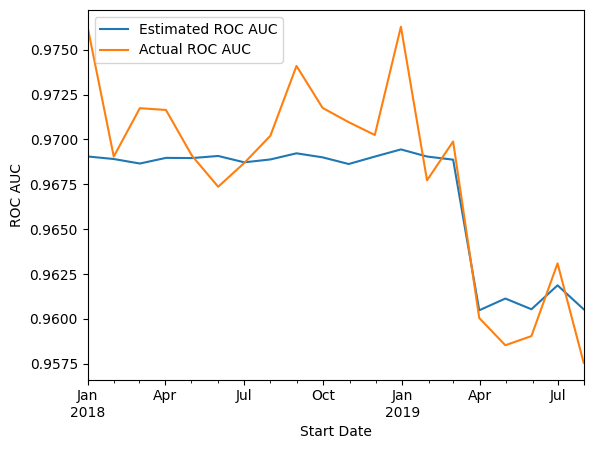

In [34]:
plot = results_df.loc[:, [('roc_auc', 'value'), ('roc_auc', 'actual'), ('chunk', 'start_date')]].plot(
    y=[('roc_auc', 'value'), ('roc_auc', 'actual')],
    x=('chunk', 'start_date'),
    xlabel='Start Date',
    ylabel='ROC AUC'
)
plot.legend(['Estimated ROC AUC','Actual ROC AUC'],loc='upper left')

plt.show()

In [35]:
figure = plot.get_figure()
figure.savefig(f'../_static/tutorials/estimated_and_realized_performance/tutorial-binary-car-loan-roc-auc-estimated-and-actual.svg')
